In [1]:
#code results in clustering by person rather than by emotion
#each cluster is the same individual
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
import matplotlib.pyplot as plt

2025-02-01 11:39:21.137523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
from glob import glob

# Configuration
DATASET_ROOT = "/Volumes/JavaAOT/Documents/AI/ml_expressions/img_datasets/jaffe_dataset"  # <- YOUR MAIN FOLDER PATH HERE
IMAGE_EXTENSIONS = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']

# Get all image paths from nested folders
def get_image_paths(root_dir, extensions):
    image_paths = []
    for ext in extensions:
        # Search through all subdirectories
        image_paths.extend(glob(os.path.join(root_dir, '**', ext), recursive=True))
    return image_paths

# Usage: Get list of all image paths
all_image_paths = get_image_paths(DATASET_ROOT, IMAGE_EXTENSIONS)
print(f"Found {len(all_image_paths)} images in nested folders")

Found 213 images in nested folders


In [3]:
#1. Feature Extraction with Pre-trained Model
# Load pre-trained model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Feature extraction function
def extract_features(image_paths, batch_size=32):
    features = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = []
        for p in batch_paths:
            img = preprocess_image(p)
            if img is not None:
                batch_images.append(img)
        
        if batch_images:
            batch_features = base_model.predict(np.array(batch_images))
            features.extend(batch_features)
    return np.array(features)

# Image preprocessing
def preprocess_image(path):
    try:
        img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
        return tf.keras.preprocessing.image.img_to_array(img)
    except Exception as e:
        print(f"Error loading {path}: {str(e)}")
        return None  # Add null handling

In [4]:
#2. Dimensionality Reduction & Clustering
def cluster_images(features, n_clusters=8):
    # Flatten features
    flattened = features.reshape(features.shape[0], -1)
    
    # Dimensionality reduction
    pca = PCA(n_components=50)
    reduced = pca.fit_transform(flattened)
    
    # Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(reduced)
    
    # Visualization
    tsne = TSNE(n_components=2, random_state=42)
    vis_features = tsne.fit_transform(reduced)
    
    plt.figure(figsize=(12, 8))
    plt.scatter(vis_features[:, 0], vis_features[:, 1], c=clusters, cmap='tab20')
    plt.title('Cluster Visualization')
    plt.show()
    
    return clusters

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


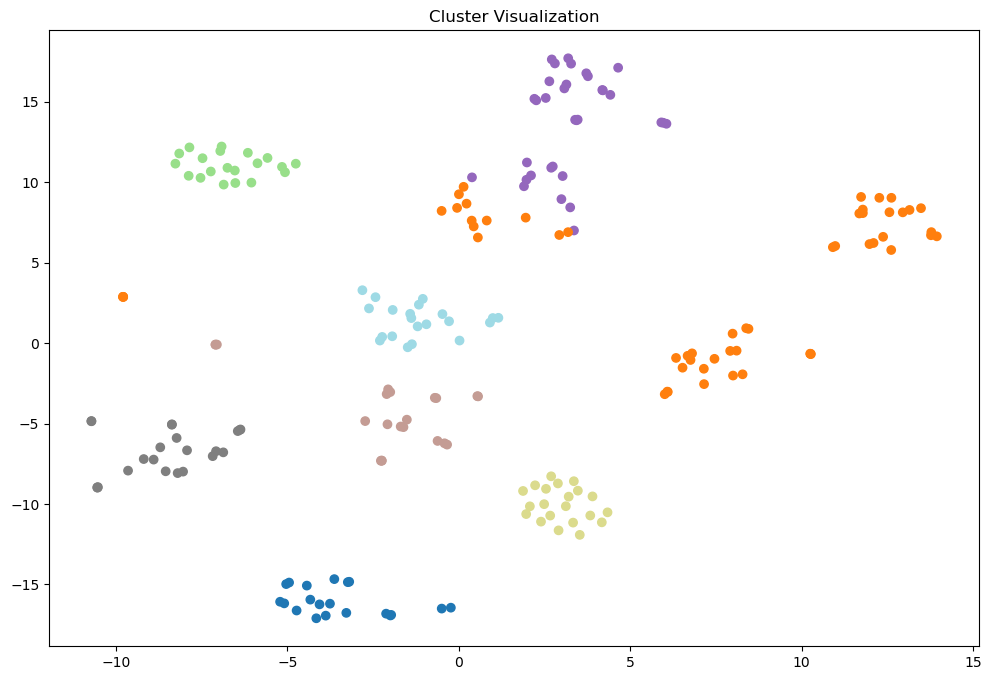

interactive(children=(IntSlider(value=0, description='cluster', max=7), Output()), _dom_classes=('widget-inter…

In [5]:
#3. Interactive Cluster Labeling
from ipywidgets import interact, IntSlider
import ipyplot

def review_cluster(image_paths, clusters, cluster_id):
    cluster_images = [path for path, c in zip(image_paths, clusters) if c == cluster_id]
    ipyplot.plot_images(
        cluster_images[:50],  # Show first 50 images
        max_images=50,
        img_width=150,
        force_b64=True
    )

# Usage after clustering:
features = extract_features(all_image_paths)
clusters = cluster_images(features)

@interact(cluster=IntSlider(min=0, max=np.max(clusters), step=1))
def show_cluster(cluster):
    review_cluster(all_image_paths, clusters, cluster)

In [7]:
#4. Semi-Supervised Training Pipeline
from tensorflow.keras import layers, models
from scipy import stats

# 1. Create pseudo-labels
pseudo_labels = clusters  # From previous step

# 2. Train initial model
def create_model():
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(np.unique(pseudo_labels)), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    return model

# 3. Train with pseudo-labels
initial_model = create_model()
initial_model.fit(
    x=np.array([preprocess_image(p) for p in all_image_paths]),
    y=pseudo_labels,
    epochs=10,
    validation_split=0.2
)

# 4. Get confidence scores
x_test = np.array([preprocess_image(p) for p in all_image_paths])
preds = initial_model.predict(x_test)
confidences = np.max(preds, axis=1)

# 5. Select high-confidence samples for manual labeling
threshold = np.quantile(confidences, 0.9)
high_confidence_samples = [p for p, c in zip(all_image_paths, confidences) if c > threshold]

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 157s 27s/step - loss: 2.1940 - val_loss: 2.1139
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 158s 25s/step - loss: 2.1647 - val_loss: 2.0321
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 161s 27s/step - loss: 2.0479 - val_loss: 2.0447
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 156s 26s/step - loss: 2.0389 - val_loss: 1.9703
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 161s 27s/step - loss: 1.9096 - val_loss: 1.9063
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 153s 25s/step - loss: 2.0151 - val_loss: 2.0482
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 157s 26s/step - loss: 2.0269 - val_loss: 1.9542
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 155s 25s/step - loss: 1.8832 - val_loss: 2.0003
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 151s 24s/step - loss: 1.7743 - val_loss: 1.7669
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 117s 19s/step - loss: 1.6897 - val_loss: 1.7274
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step


In [8]:
#5. Active Learning Interface
import csv
from IPython.display import display, clear_output
import ipywidgets as widgets

# Create labeling interface
label_selector = widgets.Dropdown(options=['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise'])
image_display = widgets.Output()
save_button = widgets.Button(description="Save Label")

current_index = 0
labels = {}

def show_next_image(b):
    global current_index
    with image_display:
        clear_output()
        display(tf.keras.preprocessing.image.load_img(high_confidence_samples[current_index]))
        
def save_label(b):
    labels[high_confidence_samples[current_index]] = label_selector.value
    show_next_image(None)
    current_index += 1

save_button.on_click(save_label)
display(widgets.VBox([image_display, label_selector, save_button]))

In [10]:
#6. Final Model Training
# Combine pseudo-labels and manual labels
final_labels = {}
for path, cluster in zip(all_image_paths, clusters):
    if path in labels:  # Use manual label if available
        final_labels[path] = labels[path]
    else:  # Use cluster-based pseudo-label
        final_labels[path] = f"cluster_{cluster}"

emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

# Convert to numerical labels
label_mapping = {emotion: idx for idx, emotion in enumerate(emotion_labels)}
y = np.array([label_mapping[final_labels[p]] for p in all_image_paths])

# Train final model with mixed labels
final_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(emotion_labels), activation='softmax')
])

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

final_model.fit(
    x=np.array([preprocess_image(p) for p in all_image_paths]),
    y=y,
    epochs=30,
    validation_split=0.2,
    class_weight=compute_class_weights(y)  # From previous implementations
)

KeyError: 'cluster_1'